## INTRODUCTION TO ENSEMBLE TRANSFORMATION   

In this notebook we will demonstrate how ensamble transformations work using probly's ensemble transformation.
The word *ensemble* refers to a group of elements that are considered together as a whole rather than individually.  
In machine learning, an ensemble is a group of models that learn the same task independently.  
 

In the following sections , we will see the demonstration on how probly transformation combines multiple independently trained models to improve prediction reliability and to measure how confident the model is about its predictions.
`Probly` already provides an *ensemble transformation* that turns a single base model into an ensemble-capable model. 


In [48]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from probly.transformation.ensemble import ensemble
from probly.representation.sampling.sample import create_sample
from probly.representation.sampling.sampler import EnsembleSampler


## DEFINE A SIMPLE MODEL AND DATA SET

In [49]:

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)




In this part, we first defined a very simple neural network called `SimpleNN`.  
It is a class which consists of two fully connected layers (`Linear`) with a ReLU activation function in between. We have also used (`Forward`) which shows how data flows through the network. 
The model takes two input features and outputs two values, one for each class in our dataset.  

We then created a small 2D classification problem that is nice to plot using the `make_moons()` function.   



## CREATE THE ENSEMBLE AND TRAIN IT 

Here, we will call the probly ensemble transformation which takes the base model (SimpleNN) and makes 3 independent copies of it.
So now we don’t have 1 model, but rather 3 models stored together.

As for the training part, each model in the ensemble will get its own optimizer, because at this point they are training separately.
We will be training for 50 epochs (each one of them one by one) using CrossEntropyLoss.

In [50]:
base_model = SimpleNN()
ensemble_model = ensemble(base_model, n_members=3)

# Create a callable wrapper for the ensemble that returns predictions from all members
class EnsembleWrapper(nn.Module):
    def __init__(self, ensemble):
        super().__init__()
        self.ensemble = ensemble
    
    def forward(self, x):
        return [member(x) for member in self.ensemble]

ensemble_wrapper = EnsembleWrapper(ensemble_model)
ensemble_sampler = EnsembleSampler(ensemble_wrapper)

optimizers = [Adam(member.parameters(), lr=0.01) for member in ensemble_model]
criterion = nn.CrossEntropyLoss()
num_epochs = 50

for epoch in range(num_epochs):
    for idx, model in enumerate(ensemble_model):
        model.train()
        optimizers[idx].zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizers[idx].step()

## EVALUATING THE ENSEMBLE

In [51]:
for member in ensemble_model:
    member.eval()

sample = ensemble_sampler.sample(X_test_tensor)
ensemble_mean = sample.mean()
_, predicted = torch.max(ensemble_mean, 1)
accuracy = (predicted == y_test_tensor).float().mean().item()
print(f"Test Accuracy: {accuracy * 100:.2f}%")



Test Accuracy: 87.00%


We put all ensemble members in eval mode (no dropout, etc.) and use `probly.representation.sampling.sampler.EnsembleSampler` to obtain and aggregate predictions from all ensemble members. The sampler automatically collects predictions from each member and creates a sample using `create_sample`, then we compute the ensemble mean. We take the argmax to compute accuracy. This demonstrates how Probly's ensemble transformation and sampling APIs work together to yield more stable predictions.

## DECISION BOUNDARY VISUALISATION

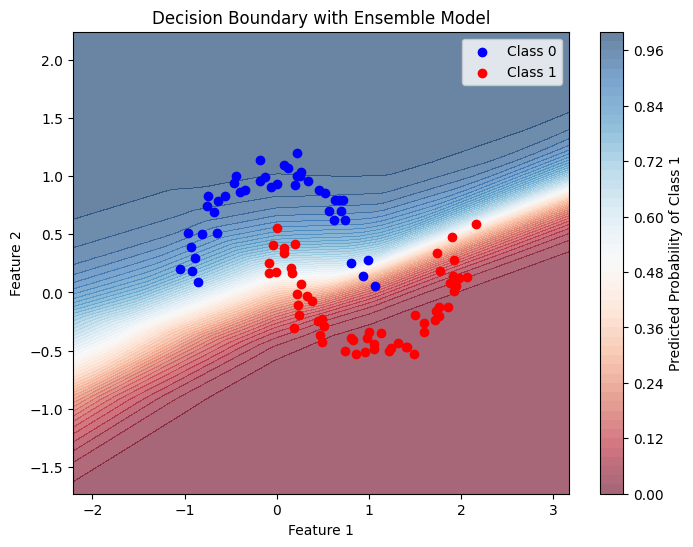

In [52]:

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x = torch.linspace(x_min, x_max, 100)
y = torch.linspace(y_min, y_max, 100)
xx, yy = torch.meshgrid(x, y, indexing='xy')
grid = torch.cat([xx.unsqueeze(-1), yy.unsqueeze(-1)], dim=-1).view(-1, 2)

for m in ensemble_model:
    m.eval()

with torch.no_grad():
    grid_sample = ensemble_sampler.sample(grid)
    grid_preds = grid_sample.mean()
    probs = torch.softmax(grid_preds, dim=-1)[:, 0].view(xx.shape)


probs_np = np.array(probs.cpu().tolist())
xx_np = np.array(xx.cpu().tolist())
yy_np = np.array(yy.cpu().tolist())

plt.figure(figsize=(8, 6))
plt.contourf(xx_np, yy_np, probs_np, levels=50, cmap='RdBu', alpha=0.6)
plt.colorbar(label='Predicted Probability of Class 1')

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='red', label='Class 1')

plt.title('Decision Boundary with Ensemble Model')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()





In this part, we create a grid that covers the entire input space and uses the trained ensemble to predict a class probability for every point in that grid.  
This allows us to visualize how the ensemble model divides the space into different classes.  

Each point on the contour plot represents the predicted probability of belonging to a specific class (here, Class 1).  
The red and blue regions show the areas where the model is confident about each class, while the boundary in between represents the uncertain region where the model is less sure.  
The scatter points correspond to the real test samples used for evaluation.


## PLOTTING UNCERTAINITY METRICS

In [53]:

def TU(probs):
    mean_prob = probs.mean(dim=1)                         
    entropy = -torch.sum(mean_prob * torch.log(mean_prob + 1e-12), dim=-1)
    return entropy.cpu().tolist()                          

def AU(probs):
    entropies = -torch.sum(probs * torch.log(probs + 1e-12), dim=-1)  
    expected_entropy = entropies.mean(dim=1)                           
    return expected_entropy.cpu().tolist()

def EU(probs):
    tu = np.array(TU(probs))
    au = np.array(AU(probs))
    return (tu - au).tolist()


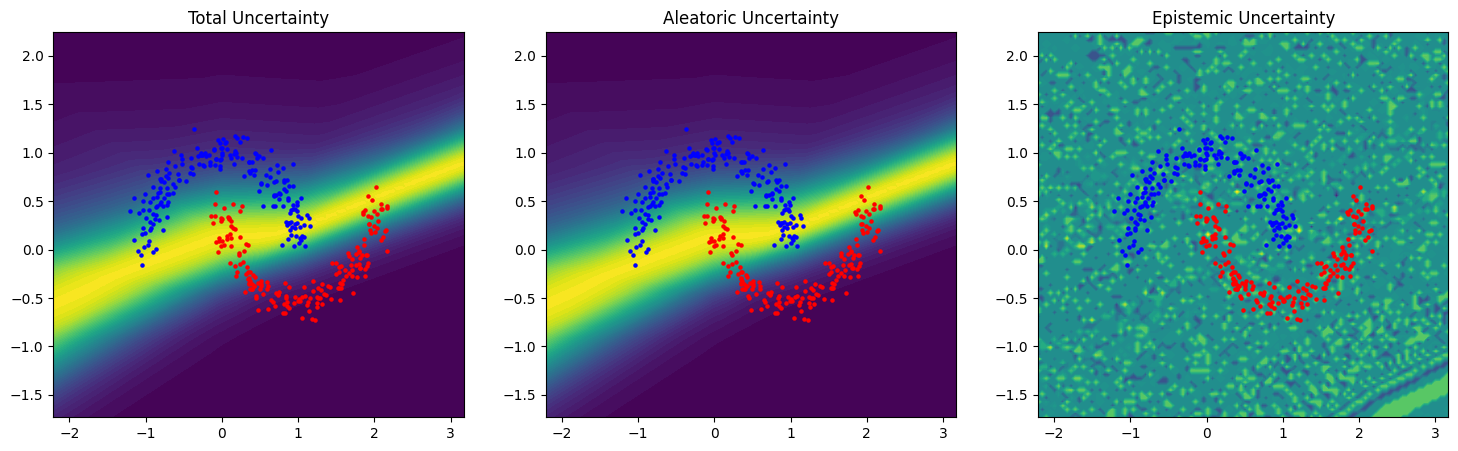

In [54]:
grid_probs = torch.softmax(grid_sample.tensor.permute(1, 0, 2), dim=-1)  


tu_values = np.array(TU(grid_probs))
au_values = np.array(AU(grid_probs))
eu_values = np.array(EU(grid_probs))


xx_np = np.array(xx.cpu().tolist())
yy_np = np.array(yy.cpu().tolist())


tu_grid = tu_values.reshape(xx_np.shape)
au_grid = au_values.reshape(xx_np.shape)
eu_grid = eu_values.reshape(xx_np.shape)


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].contourf(xx_np, yy_np, tu_grid, levels=50, cmap='viridis')
axes[0].set_title('Total Uncertainty')

axes[1].contourf(xx_np, yy_np, au_grid, levels=50, cmap='viridis')
axes[1].set_title('Aleatoric Uncertainty')

axes[2].contourf(xx_np, yy_np, eu_grid, levels=50, cmap='viridis')
axes[2].set_title('Epistemic Uncertainty')

for ax in axes:
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='blue', s=5, zorder=5)
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='red', s=5, zorder=5)

plt.show()



### Uncertainty Visualization

Here, we compute three types of uncertainty metrics for every point in the grid:
- **Total Uncertainty (TU):** overall uncertainty in the model’s predictions.  
- **Aleatoric Uncertainty (AU):** uncertainty caused by noise or overlap in the data itself.  
- **Epistemic Uncertainty (EU):** uncertainty that comes from limited knowledge or model disagreement.

By plotting these values, we can see which regions of the input space are more uncertain.  
High epistemic uncertainty usually appears in areas far from the training data, while high aleatoric uncertainty occurs where the two classes overlap.  
These visualizations demonstrate how the probly ensemble transformation adds uncertainty awareness to an otherwise deterministic neural network.


## SUMMARY

In this notebook, we used `probly.transformation.ensemble` to instantiate multiple independent copies of a base model and then trained and evaluated them. By aggregating member predictions using `probly.representation.sampling.sample.create_sample`, we obtained both stronger accuracy and interpretable uncertainty (TU, AU, EU). Modeling and training follow a standard loop; probly provides the ensemble construction and uncertainty-oriented workflow.
